In [11]:
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import random
import argparse
import networkx as nx
from itertools import combinations
import time

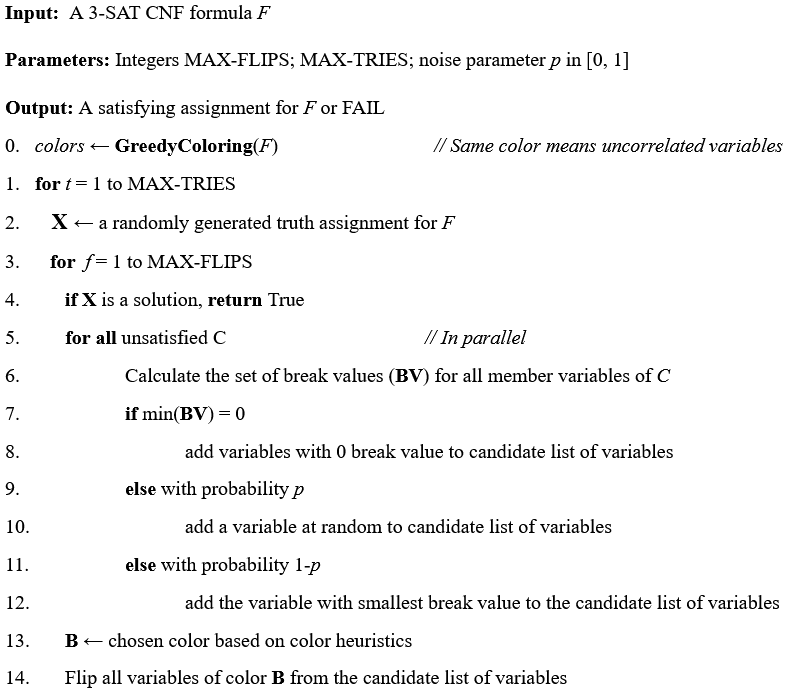

In [12]:
def read_dimacs(filename): # int num_vars, array clauses
    clauses = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('p'):
                parts = line.strip().split()
                if len(parts) >= 4:
                    _, _, variables, _ = parts[:4]
                    num_vars = int(variables)
                else:
                    raise ValueError("Invalid CNF file format in 'p' line.")
            elif line.startswith('c') or line.startswith('%') or line.startswith('0'):
                continue
            else:
                clause = list(map(int, line.strip().split()))
                # Remove the trailing 0 if present
                if clause and clause[-1] == 0:
                    clause = clause[:-1]
                if clause:
                    clauses.append(clause)
    return num_vars, clauses

def extract_problem_number(filename) -> int:
    """Extract numerical problem number from filename."""
    basename = os.path.basename(filename)
    num_str = ''.join(filter(str.isdigit, basename)) # jank the digits
    return int(num_str)


In [13]:
def walkSAT(clauses, max_tries, max_flips, p): # assignment, _Tries, _Flips, flips
    flips = 0
    def evaluate_clause(clause, assignment):
        return any((var > 0 and assignment.get(abs(var), False)) or 
                   (var < 0 and not assignment.get(abs(var), False)) for var in clause)

    def get_unsatisfied_clauses(clauses, assignment):
        return [clause for clause in clauses if not evaluate_clause(clause, assignment)]

    def get_variables(clauses):
        return set(abs(var) for clause in clauses for var in clause)

    def flip_variable(assignment, var):
        assignment[var] = not assignment[var]

    for _Tries in range(max_tries):
        variables = list(get_variables(clauses))
        assignment = {var: random.choice([True, False]) for var in variables}
        
        for _Flips in range(max_flips):

            unsatisfied = get_unsatisfied_clauses(clauses, assignment)
            if not unsatisfied:
                return assignment, _Tries, _Flips, flips  # Found a satisfying assignment
            
            clause = random.choice(unsatisfied)
            if random.random() < p:
                # Flip a random variable from the clause
                var_to_flip = abs(random.choice(clause))
            else:
                # Flip a variable that minimizes the number of unsatisfied clauses if flipped
                break_counts = []
                for var in clause:
                    assignment[abs(var)] = not assignment[abs(var)]
                    break_counts.append((len(get_unsatisfied_clauses(clauses, assignment)), abs(var)))
                    assignment[abs(var)] = not assignment[abs(var)]  # Undo the flip
                
                min_break = min(break_counts, key=lambda x: x[0])
                vars_with_min_break = [var for break_count, var in break_counts if break_count == min_break[0]]
                var_to_flip = random.choice(vars_with_min_break)
            
            flip_variable(assignment, var_to_flip)
            flips += 1

    return "FAIL"

In [14]:
from itertools import combinations

def evaluate_clause(clause, assignment):
    return any(
        (var > 0 and assignment.get(abs(var), False)) or
        (var < 0 and not assignment.get(abs(var), False))
        for var in clause
    )

def get_unsatisfied_clauses(clauses, assignment):
    return [clause for clause in clauses if not evaluate_clause(clause, assignment)]

def get_variables(clauses):
    return set(abs(var) for clause in clauses for var in clause)

def flip_variable(assignment, var):
    assignment[var] = not assignment[var]

def GenerateColors(clauses):
    variables = set(abs(literal) for clause in clauses for literal in clause)
    print(variables)
    G = nx.Graph()
    G.add_nodes_from(variables)  # Variable adjacency graph

    # If variables appear in the same clause, make an edge
    for clause in clauses:
        vars_in_clause = set(abs(literal) for literal in clause)
        for var1, var2 in combinations(vars_in_clause, 2):
            G.add_edge(var1, var2)

    # Greedy coloring , return dictionary of unique colors (0 to n) for each node
    colors = nx.coloring.greedy_color(G, strategy='largest_first')
    print(colors)
    return colors

In [15]:
def process_clause(clause, assignment, clauses, p, color_array):
    variables_in_clause = np.abs(np.array(clause, dtype=int))
    break_counts = []

    # Line 6) Calculate set of break values for all unsat C
    for x in variables_in_clause:
        assignment[x] = ~assignment[x]
        num_new_unsat = 0
        for clause_check in clauses:
            literals_check = np.array(clause_check, dtype=int)
            vars_in_clause_check = np.abs(literals_check).astype(int)
            signs_check = literals_check > 0
            clause_values_check = assignment[vars_in_clause_check]
            clause_evaluation_check = np.where(signs_check, clause_values_check, ~clause_values_check)
            if not np.any(clause_evaluation_check):
                num_new_unsat += 1
        break_counts.append(num_new_unsat)
        assignment[x] = ~assignment[x]

    candidate_list_of_variables = set() # avoid repeats
    if 0 in break_counts:
        freebie = variables_in_clause[break_counts.index(0)]
        candidate_list_of_variables.add((freebie, color_array[freebie]))

    # Pick a random variable or the min-break variable based on p
    if random.random() < p:
        x = np.random.choice(variables_in_clause)
    else:
        min_break = np.min(break_counts)
        min_indices = np.where(break_counts == min_break)[0]
        idx_min = np.random.choice(min_indices)
        x = variables_in_clause[idx_min]
    candidate_list_of_variables.add((x, color_array[x]))
    candidate_list_of_variables = list(candidate_list_of_variables)
    return candidate_list_of_variables

In [24]:
# Algorithm A1 Steps (v2):
import concurrent.futures
def AlgorithmA1(clauses, colors, max_tries, max_flips, p, heuristic_mode=0):
    """    
    clauses: array of clauses from read_cnf() 
    colors: dictionary of color memberships from GenerateColors()
    max_tries: integer of max restarts for algorithm
    max_flips: integer of iterations of algorithm for a given try
    p: probability of greedy vs random selection
    heuristic_mode: 
        0 = greedy in colors from candidate variables to flip
        1 = random from candidate variables to flip
        2 = pick a random color from candidate variables to flip
        3 = always pick first candidate variable in the candidate variables to flip
    """
    color_choice_history = [] # needed this to track how heuristic choices impact the convergence
    flips = 0
    variables = np.array(sorted(get_variables(clauses))) # Sorted list of variables
    # 1-based indexing, because 0 in cnf files is used for line breaks
    num_vars = variables[-1]
    color_array = np.zeros(num_vars + 1, dtype=int)
    for var, color in colors.items():
        color_array[var] = color
    unique_colors = np.unique(color_array[color_array > 0]) # number of unique colors
    
    for _try in range(max_tries):
        # Line 2) Random assignment
        assignment = np.random.choice([True, False], size=num_vars + 1)  # 1 based indexing

        for _flip in range(max_flips):
            # Line 5.a) Gather indeces of UNSAT clauses
            unsat_indices = []
            for idx, clause in enumerate(clauses):
                literals = np.array(clause, dtype=int)
                vars_in_clause = np.abs(literals).astype(int)
                signs = literals > 0
                clause_values = assignment[vars_in_clause]  # Get assignment values
                clause_evaluation = np.where(signs, clause_values, ~clause_values)
                # If none evaluate to 1, add to unsat index
                if not np.any(clause_evaluation):
                    unsat_indices.append(idx)

            if not unsat_indices: # Line 4) If assignment is a solution, return True
                return assignment[1:], _try, _flip, flips, color_choice_history #_flip is iteration count, flips is actual flips

            # Line 5.b) Gather UNSAT clauses
            selected_clauses = [clauses[i] for i in unsat_indices]
            candidate_list_of_variables = []

            with concurrent.futures.ThreadPoolExecutor() as executor: # Line 5) Should be in parallel.
                futures = []
                for clause in selected_clauses:
                    # Use assignment.copy() if you need to avoid concurrent mutation
                    futures.append(
                        executor.submit(process_clause, clause, assignment.copy(),
                                        clauses, p, color_array)
                    )

                for future in concurrent.futures.as_completed(futures):
                    candidate_list_of_variables.extend(future.result())

            # Line 13) Prepare the candidate list of variables for heuristics
            color_to_candidates = {}
            for x, color in candidate_list_of_variables:
                color_to_candidates.setdefault(color, []).append(x)

            # Line 14) Flip all variables of color B based on heuristics:
            # 1/4/25 added color tracking 
            if heuristic_mode == 0:
                # 5a) Flip variables of the color with the largest number of variables
                selected_color = max(color_to_candidates.keys(), key=lambda c: len(color_to_candidates[c]))
                candidates_in_color = color_to_candidates[selected_color]
                assignment[candidates_in_color] = ~assignment[candidates_in_color]
                flips += len(candidates_in_color)
                color_choice_history.append({"color": selected_color, "flips": len(candidates_in_color)})
            elif heuristic_mode == 1:
                # 5b) Randomly pick a variable from candidate variables to flip
                var_to_flip = np.random.choice([x for x, _ in candidate_list_of_variables])
                assignment[var_to_flip] = ~assignment[var_to_flip]
                flips += 1
                color_choice_history.append({"color": color_array[var_to_flip], "flips": 1})
            elif heuristic_mode == 2:
                # 5c) Randomly pick a color, flip all variables of that color
                selected_color = np.random.choice(list(color_to_candidates.keys()))
                candidates_in_color = color_to_candidates[selected_color]
                assignment[candidates_in_color] = ~assignment[candidates_in_color]
                flips += len(candidates_in_color)
                color_choice_history.append({"color": selected_color, "flips": len(candidates_in_color)})
            elif heuristic_mode == 3:
                # 5d) Always pick the first candidate variable to flip
                var_to_flip = candidate_list_of_variables[0][0]
                assignment[var_to_flip] = ~assignment[var_to_flip]
                flips += 1
                color_choice_history.append({"color": color_array[var_to_flip], "flips": 1})
    return "FAIL"

In [30]:
import os
import glob
import json
import time
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np

cnf_file = "/home/dae/SatExperiments/ColoringWalksatExperiments/uf50suiteSATLIB/uf5002.cnf"
problem_name = os.path.basename(cnf_file)
num_vars, clauses = read_dimacs(cnf_file)
start = time.perf_counter()
colors = GenerateColors(clauses)
max_flips_var = 10000 # same as tinish paper

# 1 29s
# 0 is taking 57
# 2  151
# 3 22s
solution_object = AlgorithmA1(clauses, colors, max_tries=1, max_flips=max_flips_var, p=0.5, heuristic_mode=0)
end = time.perf_counter()
print(str((end-start)))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50}
{31: 0, 8: 0, 9: 1, 38: 2, 21: 1, 28: 3, 1: 1, 22: 2, 4: 3, 14: 4, 27: 2, 32: 2, 44: 5, 13: 5, 29: 3, 36: 3, 15: 0, 17: 5, 19: 4, 41: 6, 3: 1, 12: 6, 26: 7, 35: 7, 10: 6, 33: 4, 42: 6, 46: 6, 48: 7, 18: 4, 45: 8, 50: 3, 39: 7, 5: 1, 23: 2, 43: 5, 47: 8, 7: 0, 16: 7, 37: 8, 49: 5, 2: 3, 6: 0, 11: 9, 20: 0, 25: 9, 30: 8, 34: 9, 24: 9, 40: 2}
1.2852207208052278


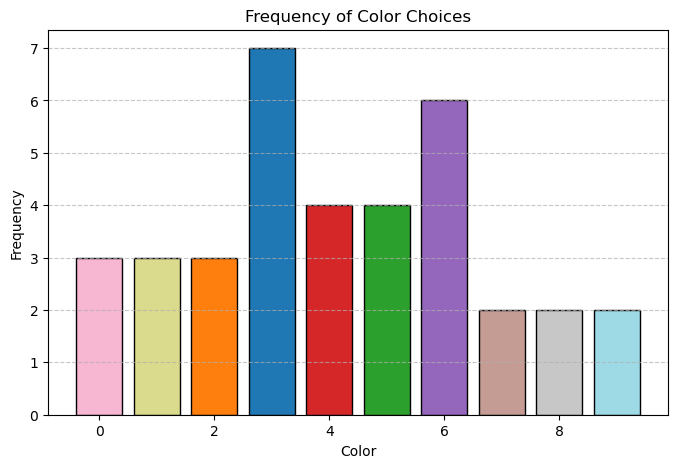

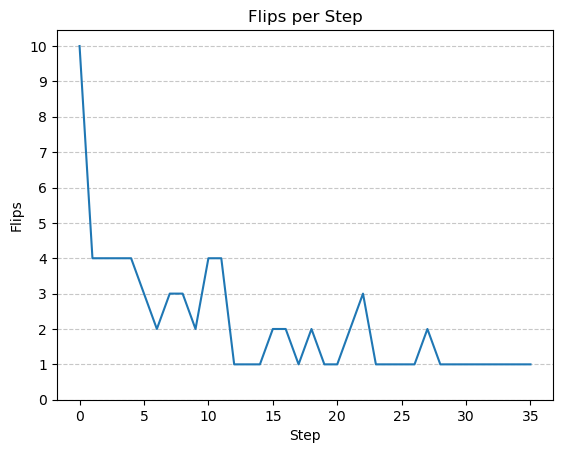

In [36]:
import matplotlib.pyplot as plt
from collections import Counter
assignment, tries,iterations, flips, color_order =  solution_object

colors = [entry["color"] for entry in color_order]
counts = Counter(colors)

# Assign a unique color to each bar
unique_colors = list(counts.keys())
bar_colors = plt.cm.tab20(np.linspace(0, 1, len(unique_colors)))  # Use a colormap for distinct colors

plt.figure(figsize=(8, 5))
plt.bar(counts.keys(), counts.values(), color=bar_colors, edgecolor="black")
plt.xlabel("Color")
plt.ylabel("Frequency")
plt.title("Frequency of Color Choices")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

flips = [entry["flips"] for entry in color_order]
plt.plot(flips)
plt.xlabel("Step")
plt.ylabel("Flips")
plt.title("Flips per Step")
plt.grid(axis="y", linestyle="--", alpha=0.7)
max_flips = max(flips)
plt.yticks(np.arange(0, max_flips + 1, 1))
plt.show()


In [ ]:
# Now what to plot:

# Run length distribution
# Success rate
# Instance-wise flips to solution
# Batch wise flips to solution

# Color choice distribution for the batch
# Color choice during solving per instance
# Color choice domain plots with instance-wise flips to solution range
# Parallelism % domain heuristic plots with instance-wise flips to solution range


In [ ]:
# Part of the code that runs the algorithm in parallel
import os
import glob
import json
import time
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np

# ML-style checkpoints, in case this crashes overnight.
CHECKPOINT_FILE = "sat_solver_checkpoint.json"
def load_checkpoint():
    if os.path.exists(CHECKPOINT_FILE):
        with open(CHECKPOINT_FILE, "r") as file:
            return json.load(file)
    return {}

def save_checkpoint(data):
    with open(CHECKPOINT_FILE, "w") as file:
        json.dump(data, file)

def process_file(file_path):
    # Example SAT solver processing
    try:
        # Simulated solver logic (replace with actual implementation)
        problem_name = os.path.basename(file_path)
        tts = np.random.uniform(0.1, 10)  # Example: Time to solution
        flips = np.random.randint(100, 10000)  # Example: Flips to solution
        return problem_name, tts, flips
    except Exception as e:
        return os.path.basename(file_path), None, None

def main():
    # Load checkpoint
    checkpoint = load_checkpoint()
    processed_problems = set(checkpoint.get("processed_problems", []))
    results = checkpoint.get("results", [])

    # File handling and setup
    problem_dir = "uf50suiteSATLIB"
    files = sorted([os.path.join(problem_dir, f) for f in os.listdir(problem_dir) if f.endswith(".cnf")])

    # Parallel processing
    num_workers = max(1, int(0.2 * multiprocessing.cpu_count()))
    with multiprocessing.Pool(num_workers) as pool:
        for result in pool.imap(process_file, files):
            problem_name, tts, flips = result
            if problem_name in processed_problems:
                continue
            processed_problems.add(problem_name)
            results.append({"problem": problem_name, "tts": tts, "flips": flips})

            # Save checkpoint periodically
            checkpoint = {"processed_problems": list(processed_problems), "results": results}
            save_checkpoint(checkpoint)

    # Plot results
    tts_values = [r["tts"] for r in results if r["tts"] is not None]
    flips_values = [r["flips"] for r in results if r["flips"] is not None]
    problem_names = [r["problem"] for r in results]

    plt.plot(range(len(tts_values)), tts_values, label="TTS")
    plt.xlabel("Problem Index")
    plt.ylabel("Time to Solution")
    plt.legend()
    plt.show()

    plt.plot(range(len(flips_values)), flips_values, label="Flips")
    plt.xlabel("Problem Index")
    plt.ylabel("Flips to Solution")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()




























def process_file(cnf_file):
    import time
    max_flips_var = 10000
    p = 0.5

    problem_name = os.path.basename(cnf_file)
    num_vars, clauses = read_dimacs(cnf_file)
    start = time.perf_counter()
    colors = GenerateColors(clauses)
    solution_object = AlgorithmA1(clauses, colors, max_tries=1, max_flips=max_flips_var, p=0.5, heuristic_mode=0)
    end = time.perf_counter()

    if solution_object != "FAIL":  # we found a satisfying model
        time_to_solution = end - start  # seconds
        flips = solution_object[2] # number of flips
        print(f"{problem_name}: Time = {time_to_solution:.4f}s, Flips = {flips}")
        return (problem_name, time_to_solution, flips) # tuple of problem name, TTS, flips
    else:
        print(f"{problem_name}: Failed to find a solution")
        # Return None for time and flips (thanks George for suggestion)
        return (problem_name, None, None)

def main():
    # Adding new figures of merit

    problem_names = []
    times_to_solution = []
    flips_to_solution = []
    cnf_directory = "/home/dae/SatExperiments/juniper/uf50suiteSATLIB/"
    cnf_files = glob.glob(os.path.join(cnf_directory, "uf50*.cnf")) # get all uf50* files
    cnf_files.sort(key=extract_problem_number) # sort files based on  numerical part of the filename

    total_cpus = multiprocessing.cpu_count()
    num_workers = max(1, int(total_cpus * 0.2)) # use 20% of cores - tinish is benchmarking
    print(f"Total CPU cores: {total_cpus}, Using {num_workers} worker processes.")

    with multiprocessing.Pool(processes=num_workers) as pool: # do the benchmarking in parallel
        results = pool.map(process_file, cnf_files)

    if results:
        problem_names, times_to_solution, flips_to_solution = zip(*results)
    else:
        print("No results error.")
        return

    times_to_solution = np.array(times_to_solution, dtype=float)
    flips_to_solution = np.array(flips_to_solution, dtype=float)

    # take only the first 100 results to plot
    times_to_solution = times_to_solution[0:100]
    flips_to_solution = flips_to_solution[0:100]
    problem_names = problem_names[0:100]

    # Time to solution
    plt.figure(figsize=(14, 7))
    plt.plot(problem_names, times_to_solution, marker='o', linestyle='-', label='Time to Solution')
    plt.xlabel('Problem Name')
    plt.ylabel('Time to Solution TTS (s)')
    plt.title('Time to Solution for First 100 Problems in uf50suiteSATLIB for 100000 MaxFlips 1 Try')
    plt.xticks(rotation=90)
    plt.grid(True)

    failed_indices = np.where(np.isnan(times_to_solution))[0] # if there are any NaN solutions (fails) highlight them
    if failed_indices.size > 0:
        plt.scatter(np.array(problem_names)[failed_indices], 
                    np.zeros_like(failed_indices), 
                    color='red', marker='x', label='Failed to find a solution')

    plt.legend()
    plt.tight_layout()
    plt.show()

    # Flips to solution
    plt.figure(figsize=(14, 7))
    plt.plot(problem_names, flips_to_solution, marker='o', linestyle='-', label='Flips to Solution')
    plt.xlabel('Problem Name')
    plt.ylabel('Flips to Solution (int)')
    plt.title('Flips to Solution for First 100 Problems in uf50suiteSATLIB for 100000 MaxFlips 1 Try')
    plt.xticks(rotation=90)
    plt.grid(True)

    if failed_indices.size > 0: # if there are any NaN solutions (fails) highlight them
        plt.scatter(np.array(problem_names)[failed_indices], 
                    np.zeros_like(failed_indices), 
                    color='red', marker='x', label='Failed to find a solution')

    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Total CPU cores: 64, Using 32 worker processes.


uf50081.cnf: Time = 1.4612s, Flips = 59
uf50089.cnf: Time = 2.0838s, Flips = 49
uf50090.cnf: Time = 0.6913s, Flips = 26
uf500225.cnf: Time = 2.9042s, Flips = 129
uf5009.cnf: Time = 3.4662s, Flips = 124
uf500153.cnf: Time = 3.5333s, Flips = 181
uf50082.cnf: Time = 2.1474s, Flips = 130
uf500161.cnf: Time = 4.0090s, Flips = 203
uf50033.cnf: Time = 4.1332s, Flips = 298
uf5001.cnf: Time = 4.2242s, Flips = 136
uf500185.cnf: Time = 4.7260s, Flips = 184
uf500113.cnf: Time = 5.1103s, Flips = 233
uf50041.cnf: Time = 5.4982s, Flips = 203
uf50083.cnf: Time = 2.2589s, Flips = 86
uf500233.cnf: Time = 6.2180s, Flips = 456
uf500137.cnf: Time = 7.3504s, Flips = 330
uf500114.cnf: Time = 2.2482s, Flips = 71
uf50091.cnf: Time = 4.6519s, Flips = 241
uf500115.cnf: Time = 0.9445s, Flips = 22
uf500177.cnf: Time = 8.5439s, Flips = 426
uf500186.cnf: Time = 3.7453s, Flips = 214
uf500201.cnf: Time = 8.8871s, Flips = 585
uf500105.cnf: Time = 9.0978s, Flips = 679
uf50034.cnf: Time = 5.2637s, Flips = 502
uf500234.cn